In [1]:
# start by loading data on the returns of the market portfolio and the risk-free rate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Value investing

One of the most popular quantitative investing strategies is broadly refered to as "value investing"

* It consists of tilting the portfolio towards stocks that have a low price relative to a proxy for it's fundamental value

* and tilt away form stocks with high price relative to fundamentals

* Broadly speaking: Buy cheap, sell expensive

* weights: 

$$W_t \propto \frac{F_t}{P_t}$$

* Where $F_t$ is some proxy for the firm's fundamental value

* typically some accounting measure

* There is a vast number of proxys for fundamentals

  * Dividends
  * Book value
  * Earnings
  * Cash flows
  * Sales
  
* The strategy is the "cross-sectional" counterpart of market timing strategies that rely on earnings to price ratio of aggregate market as a proxy for whether the market is expensive or cheap

* However, the evidence is that cross-sectional strategy is much more reliable, even if it still quite risky. It actually has done terribly in the last 10 years!




In [3]:
url = "https://www.dropbox.com/s/lyvzy649na6p8su/value_characteristic.csv?dl=1"
parser = lambda date: pd.to_datetime(date,format='%m%y')
Data = pd.read_csv(url,parse_dates=[0])
Data

,date,permno,re,rf,size,value
0,1972-07-01,10006,0.028600,0.0031,12.399869,-0.125361
1,1972-07-01,10102,0.039757,0.0031,12.217334,0.354954
2,1972-07-01,10137,-0.044767,0.0031,13.069874,-0.088697
3,1972-07-01,10145,-0.062422,0.0031,13.608366,0.075484
4,1972-07-01,10153,-0.065600,0.0031,11.752572,0.944457
...,...,...,...,...,...,...
486422,2016-12-01,93420,0.011056,0.0003,14.337515,1.049163
486423,2016-12-01,93422,-0.063881,0.0003,15.256946,0.829353
486424,2016-12-01,93423,0.039950,0.0003,15.502888,-2.128977
486425,2016-12-01,93429,0.072124,0.0003,15.504722,-3.001095


In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486427 entries, 0 to 486426
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    486427 non-null  datetime64[ns]
 1   permno  486427 non-null  int64         
 2   re      486427 non-null  float64       
 3   rf      486427 non-null  float64       
 4   size    486427 non-null  float64       
 5   value   486427 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 22.3 MB


- above we load a data set with our value signal, Book-to-Market already constructed. Here is the definition of the value variable:
     
     >Value (annual) (value). Follows Fama and French (1993). value = log(BE/ME). At the end of June of each year, we use book equity from the previous fiscal year and market equity from December of the previous year. Rebalanced annually. 

- The data set also containts a size variable:

   > Size (size). Follows Fama and French (1993). size = MEJun. The CRSP end of June price times shares outstanding. Rebalanced annually
   
And contains excess returns (re) for individual stocks and the risk-free rate  of the relvant date

- permno is an identifier for the stock

- Note the format of the data set where stock and dates are stacked vertically

- We will need two indexes (date and permno) to perfectly identify an observation


##### ->This means we will start with step 1 already done for us (signal construction), and we will move directly to step 2

Details on how the value signal was constructed
* Value portfolios are typically rebalanced every July using Book-to-Market data from the year before    
* This means that from July/2006 to June/2007 you use Book-to-Market data from December/2005
* Because the way we construct the data, the BM data is the same from Jan/2005 to December/2005

###### What is important is that it is lagged by at least 12 months, to make sure that the BM data was available at the day of portfolio formation!

In [5]:
# We will shift the date to end of month as I know that july here means the return for buying end of june, selling end of july

Data.date=Data.date+pd.tseries.offsets.MonthEnd()
Data

,date,permno,re,rf,size,value
0,1972-07-31,10006,0.028600,0.0031,12.399869,-0.125361
1,1972-07-31,10102,0.039757,0.0031,12.217334,0.354954
2,1972-07-31,10137,-0.044767,0.0031,13.069874,-0.088697
3,1972-07-31,10145,-0.062422,0.0031,13.608366,0.075484
4,1972-07-31,10153,-0.065600,0.0031,11.752572,0.944457
...,...,...,...,...,...,...
486422,2016-12-31,93420,0.011056,0.0003,14.337515,1.049163
486423,2016-12-31,93422,-0.063881,0.0003,15.256946,0.829353
486424,2016-12-31,93423,0.039950,0.0003,15.502888,-2.128977
486425,2016-12-31,93429,0.072124,0.0003,15.504722,-3.001095


#### What does the value signal look like?

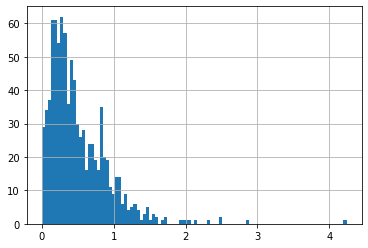

In [6]:
# lets look at what out value measure looks like for a particular date:
np.exp(Data[Data.date=='2016-12-31'].value).hist(bins=100)


- A lot of cross-section variation across firms

- some firms have very low book-to-market: accounting value low relative to market value

- Other firms have high book to market: accounting value high relative to market value

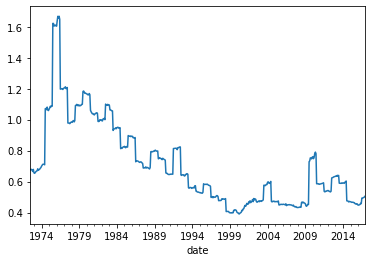

In [7]:
# lets look overtime

Data.groupby(by='date').value.apply(lambda x: np.exp(x).mean()).plot()

* a lot of time-variation in it

  * everything tends to be value at the same time 
  
* instead of time-variation, strategy that we want to construct want to explore variation across stocks

* lets look at how the signal dispersion changed



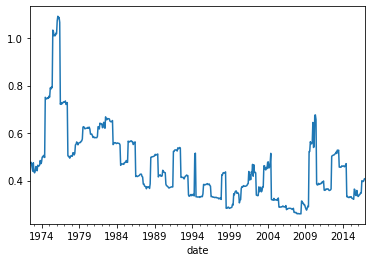

In [8]:
Data.groupby(by='date').value.apply(lambda x: np.exp(x).std()).plot()

### Quantitative investing is all about ranking

* [$\checkmark$] Get returns for each asset

* [$\checkmark$] Construct the signals for each asset

- \[X\]  Rank the signals in each date

- \[X\]  Choose how many assets to pool together. Trade-off between signal strength and diversification

     * If you only buy the highest signal asset, you lose diversification

### How to rank?


- We will assign the stocks in to quantiles according to it's relative characteristic position in the particular date

In [26]:
df=Data.copy()

We now do both the ranking and grouping in one single command

* Here we use `qdcut` to split the portfolios by Book-to-Market into 10 quantiles

  (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)
  
* The key here is to use the groupby operation to group things by date and do the quantile grouping in each date

* For each date, Pandas ranks portfolios and labels the lowest portfolio $0$

* Because Pandas ranking starts at 0, we add 1 so our portfolio ranks are from 1 to 5

In [23]:
df.groupby(['date'])['value'].mean()

date
1972-07-31   -0.626205
1972-08-31   -0.623892
1972-09-30   -0.620197
1972-10-31   -0.624844
1972-11-30   -0.635536
                ...   
2016-08-31   -1.055661
2016-09-30   -1.048324
2016-10-31   -1.047085
2016-11-30   -1.042955
2016-12-31   -1.022753
Name: value, Length: 534, dtype: float64

In [34]:
df[df.date=='1972-07-31'].sort_values(by='value').head(50)

,date,permno,re,rf,size,value,value_group
678,1972-07-31,42753,-0.191779,0.0031,11.485841,-3.347548,0.0
560,1972-07-31,34649,-0.450313,0.0031,12.852010,-3.321926,0.0
767,1972-07-31,47335,0.059757,0.0031,13.506375,-2.901124,0.0
631,1972-07-31,40416,0.040664,0.0031,15.698746,-2.885152,0.0
541,1972-07-31,31659,0.060031,0.0031,12.844695,-2.804002,0.0
650,1972-07-31,41419,-0.102152,0.0031,13.629061,-2.697078,0.0
585,1972-07-31,38324,-0.052893,0.0031,13.967502,-2.696856,0.0
310,1972-07-31,22648,0.051588,0.0031,13.005848,-2.692740,0.0
594,1972-07-31,38850,-0.079593,0.0031,13.532816,-2.656754,0.0
713,1972-07-31,44644,0.069934,0.0031,13.124501,-2.521507,0.0


In [37]:
ngroups=10
df['value_group']=df.groupby(['date'])['value'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
df

,date,permno,re,rf,size,value,value_group
0,1972-07-31,10006,0.028600,0.0031,12.399869,-0.125361,7.0
1,1972-07-31,10102,0.039757,0.0031,12.217334,0.354954,9.0
2,1972-07-31,10137,-0.044767,0.0031,13.069874,-0.088697,7.0
3,1972-07-31,10145,-0.062422,0.0031,13.608366,0.075484,8.0
4,1972-07-31,10153,-0.065600,0.0031,11.752572,0.944457,9.0
...,...,...,...,...,...,...,...
486422,2016-12-31,93420,0.011056,0.0003,14.337515,1.049163,9.0
486423,2016-12-31,93422,-0.063881,0.0003,15.256946,0.829353,9.0
486424,2016-12-31,93423,0.039950,0.0003,15.502888,-2.128977,1.0
486425,2016-12-31,93429,0.072124,0.0003,15.504722,-3.001095,0.0


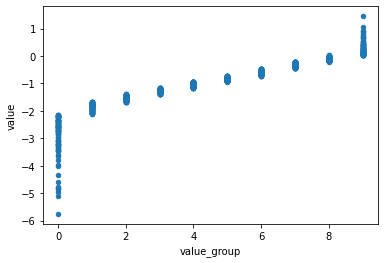

In [11]:
# vizualization

df[df.date=='2016-12-31'].plot.scatter(x='value_group',y='value')

#### From signals to weights: Portfolio formation tradeoffs

* We will start by constructing Equal weighted portfolios within each signal bucket

* Why not sort in 100 groups instead on only 10? This way your top value would be much more value

* Why no simply focus on the highest value stock?


  1. Individual stocks have $\sigma$ = 40 − 80%, so $\sigma/\sqrt{T}$ makes it nearly impossible to accurately measure E(R). Portfolios have lower $\sigma$ by diversification.
  2. So if you have to trade-off strengh of the signal against benefits of diversification

### Calculate the portfolio return

$$\sum_i^I W_{it} R_{it}$$

Where the weights must add up to 1.

In [38]:
# lets start by constructin equal weighted portfolios because they are easy

value=df.groupby(by=['date','value_group']).re.mean()
value.head(20)

date        value_group
1972-07-31  0.0           -0.019413
            1.0           -0.031952
            2.0           -0.020647
            3.0           -0.035959
            4.0           -0.024635
            5.0           -0.039905
            6.0           -0.021154
            7.0           -0.020123
            8.0           -0.007755
            9.0           -0.019082
1972-08-31  0.0           -0.001142
            1.0           -0.005426
            2.0            0.023772
            3.0            0.022265
            4.0            0.045362
            5.0            0.034890
            6.0            0.030207
            7.0            0.046286
            8.0            0.046104
            9.0            0.061007
Name: re, dtype: float64

###### -> Why does the mean operator implements the Equal weighted portfolio?

In [39]:
# to look we wiill first unstack

value=value.unstack(-1)
value

value_group,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
date,,,,,,,,,,
1972-07-31,-0.019413,-0.031952,-0.020647,-0.035959,-0.024635,-0.039905,-0.021154,-0.020123,-0.007755,-0.019082
1972-08-31,-0.001142,-0.005426,0.023772,0.022265,0.045362,0.034890,0.030207,0.046286,0.046104,0.061007
1972-09-30,-0.017616,-0.016387,-0.034466,-0.036333,-0.017730,-0.009669,-0.021047,-0.020553,-0.024226,-0.040173
1972-10-31,-0.019626,-0.025251,-0.001835,-0.014175,0.008467,0.004370,0.023685,0.022813,0.000293,-0.013171
1972-11-30,0.032307,0.051885,0.046909,0.062400,0.067479,0.060958,0.070035,0.072612,0.072457,0.091100
...,...,...,...,...,...,...,...,...,...,...
2016-08-31,-0.001996,-0.002620,0.006674,0.013181,-0.005727,0.013239,0.014881,0.009360,0.005812,0.017716
2016-09-30,0.000467,0.000368,-0.009791,-0.006281,-0.002992,0.012975,0.003570,0.006279,0.010710,0.013285
2016-10-31,-0.041339,-0.036376,-0.025003,-0.024703,-0.032303,-0.019515,-0.012217,-0.012475,-0.004770,-0.026986


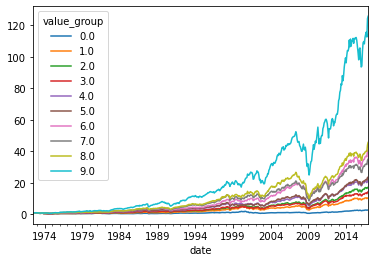

In [40]:
(value+1).cumprod().plot()

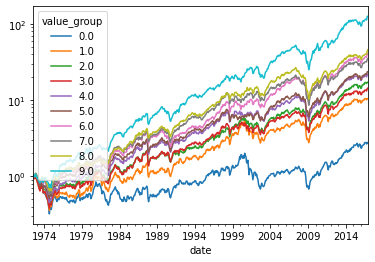

In [41]:
(value+1).cumprod().plot(logy=True)

#### What do you see here?

- Over time "value" (high book to market) stocks tend to perform well going forward

- "growth" stocks  (low book to market) tend to perform poorly going forward

- You can implement a value strategy in a varity of ways depending of what you can do

     - instead of buying the market just buy portfolios 5 to 9, or even only portfolio 9
     
     - Or are you can also buy portfolio 9 and SHORT portfolio 0, that is a value minus growth strategy. Nice becasue it is close to market neutral so you can add market exposure on top of that. But of course, you do need to short!
     
   

### Long-short portfolio


* What is a long-short portfolio?

* It is a portfolio that is self-financed, for each dollar of stocks that it buys, it finances the position by shorting 1 dollar worth of stock in the other side

* So the returns of long-short portfolio are already excess returns

* We have worked with long-short portfolios before starting Notebook 3

* But there our short side was always the risk-free rate

   * When we write $R^e_{mkt}=R_{mkt}-R_f$, we are constructing a long-short portfolio that goes long the market and short the risk-free asset
   
   * This portfolio as we discussed in Notebook 3 has zero cost, i.e., you don't need any capital, so it allow us to completely separate the time-value of money question from the risk premium question
   
   * The only difference is that now our short side will be a risky asset too, but the logic is the same
   

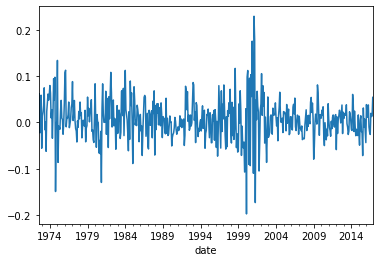

In [42]:
R_HmL=value[9].subtract(value[0])

(R_HmL).plot()
plt.show()

###### Attention: R_hml is an excess return! to look at cumulative returns overtime we need to add back  the risk-free rate to it



In [43]:
rf=df.groupby(by='date').rf.mean()
rf

date
1972-07-31    0.0031
1972-08-31    0.0029
1972-09-30    0.0034
1972-10-31    0.0040
1972-11-30    0.0037
               ...  
2016-08-31    0.0002
2016-09-30    0.0002
2016-10-31    0.0002
2016-11-30    0.0001
2016-12-31    0.0003
Name: rf, Length: 534, dtype: float64

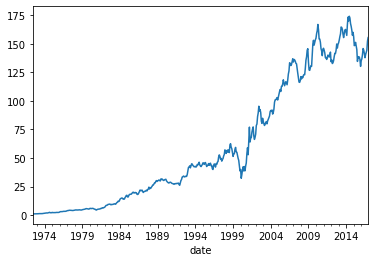

In [44]:
# note that here pandas is doing this seemlessly without need an explicit merge operation becasue the dataset 
# are already alined
# as they were constructed form the same data set and have the same indnetical index.
(R_HmL+rf+1).cumprod().plot()

## Value-weighted portfolios

* We have so far focused on Equal-weighted portfolios

* This is fine in this case as the industries themselves are Value-weighted

* When working with stocks, if you EW you most load on tiny stocks

* So whatever pattern you find is unlikely to be tradable, because small stocks tend to be very illiquid

* Even if tradable, the scale of the strategy will be quite limited as prices will move quickly up as you start to buy

* So lets construct Market-Cap weighted portfolio

* These portfolios buy in proportion to the market cap of the firm, so small stocks will only get a small allocation to it

* This makes the portfolios much easier to trade

* Doing this is very easy, essentially a weighted average of returns

* Here is more involved because we need to construct the market cap measure and merge back to our original data set before doing the final step


In [ ]:
df

In [46]:

# For a given date, for a given group, take the value-weighted average return
def wavg(group):
    d = group['re']
    w = group['size']
    try:
            return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

ngroups=10
df['value_group']=df.groupby(['date'])['value'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))

value_sizeweighted = df.groupby(['date','value_group']).apply(wavg)

value_sizeweighted=value_sizeweighted.unstack(level=-1)

value_sizeweighted.head()

value_group,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
date,,,,,,,,,,
1972-07-31,-0.016512,-0.029192,-0.020649,-0.034619,-0.025278,-0.037691,-0.020747,-0.020043,-0.008014,-0.019219
1972-08-31,-0.000045,-0.004055,0.023487,0.023287,0.046704,0.035910,0.032162,0.046798,0.048889,0.061428
1972-09-30,-0.016667,-0.014786,-0.033966,-0.036410,-0.017814,-0.009716,-0.021399,-0.020599,-0.023082,-0.040054
1972-10-31,-0.017074,-0.022969,-0.000557,-0.013126,0.009148,0.004804,0.023004,0.022681,0.001232,-0.012606
1972-11-30,0.030157,0.050792,0.047116,0.063041,0.068412,0.060683,0.069578,0.073453,0.073004,0.092717


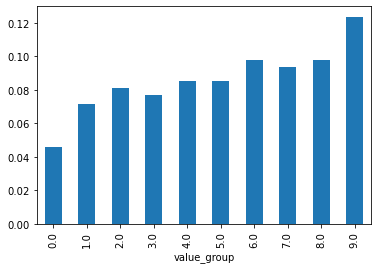

In [50]:
(value_sizeweighted.mean()*12).plot.bar()

* It is important when constructing any weights that the weights you are using are a function only of variables known before the time of the trade.

* Here in this case we are using the size variable which is the market cap of the firm last december as explained above

* what is important is that this info is tradable, ideally we would use more recent market caps, but market caps are very persistent, so the result will be similar

* If you didn't lag what would it be the problem? That is suppose that you use market cap from the end of the trading month? What bias would that introduce? Would this be a valid strategy?

